In [1]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as u
from astropy.visualization import AsinhStretch, ImageNormalize
from regions import Regions
from analysis_utils import plot_2D_map, imfit_wrapper, get_projected_coord, get_radec_coord, calc_radial_profile, get_spectral_coord
import casatasks
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)
%matplotlib widget
%load_ext autoreload
%autoreload 2

from matplotlib import colors
freeze = np.loadtxt('/home/yamato/Project/MAPS/script/MAPS_cmap.txt')
freeze /= 255.0
cpal = colors.ListedColormap(freeze, name='freeze')

In [2]:
imagepath = "/raid/work/yamato/eDisk_data/L1489IRS/v0_images/C18O/L1489IRS_SBLB_C18O_robust_1.5.image.fits"

header = fits.getheader(imagepath)
data = fits.getdata(imagepath)

cutout = (slice(None), slice(1000, 3000), slice(1000,3000))

data = data[cutout] # needed to save the memory

beam = (header['BMAJ'] * 3600, header['BMIN'] * 3600, 90 - header['BPA'])
scale = (50 / 140, '50 au')

# 2D Gaussian fit result
fitfile = "./L1489IRS_cont_imfit.result.pkl"

with open(fitfile, 'rb') as f:
    fitresult = pickle.load(f)

incl = fitresult['component1']['inclination'].value
PA = fitresult['component1']['size']['pa'].value

In [3]:
# make directional mask based on the 2D Gaussian fit result
center_coord = fitresult['component0']['peak']

x, y = get_radec_coord(header, center_coord=center_coord)
x = x[cutout[2]]
y = y[cutout[1]]
xx, yy = np.meshgrid(x, y)
r = np.sqrt(xx**2 + yy**2)

# nominal emisison extent measured by eye on the CARTA viewer in arcsec
r_out = 10
mask = np.ones(data.shape[1:])
mask[r > r_out] = 0.0

# use edge channels in both ends
nchan = data.shape[0]
channels = np.arange(nchan)
edge_nchan = 20
channel_mask = np.ones(nchan)
channel_mask[np.logical_and(channels >= edge_nchan, channels < nchan-edge_nchan)] = 0.0

noise_mask = np.logical_and(mask[None, :, :], channel_mask[:, None, None])

# calculate rms
from analysis_utils import calc_rms
rms = calc_rms(data * noise_mask)
print(rms, header['BUNIT'])

0.0015651494097443997 Jy/beam


In [4]:
# simple channel mask
channel_mask = np.ones(nchan)
# from CARTA viewer
firstchannel = 51
lastchannel = 118
channel_mask[(channels < firstchannel) | (channels > lastchannel)] = 0.0

emission_mask = np.logical_and(mask[None, :, :], channel_mask[:, None, None])
masked_data = emission_mask * data

In [5]:
# calculate mom0
v = get_spectral_coord(header, which='vel')
print("Will integrated over {:.2f} km/s -- {:.2f} km/s".format(v[firstchannel], v[lastchannel]))
dchan = np.diff(v).mean()
M0 = np.trapz(masked_data, dx=dchan, axis=0)

Will integrated over 1.52 km/s -- 12.71 km/s


[(5.0, -5.0),
 (-5.0, 5.0),
 Text(0.5, 0, '$\\Delta\\alpha\\cos(\\delta)$ [arcsec]'),
 Text(0, 0.5, '$\\Delta\\delta$ [arcsec]'),
 Text(0.5, 1.0, 'C$^{18}$O ($J=$ 2-1) moment 0; 0.129" $\\times$ 0.099", rms = 1.6 mJy/beam')]

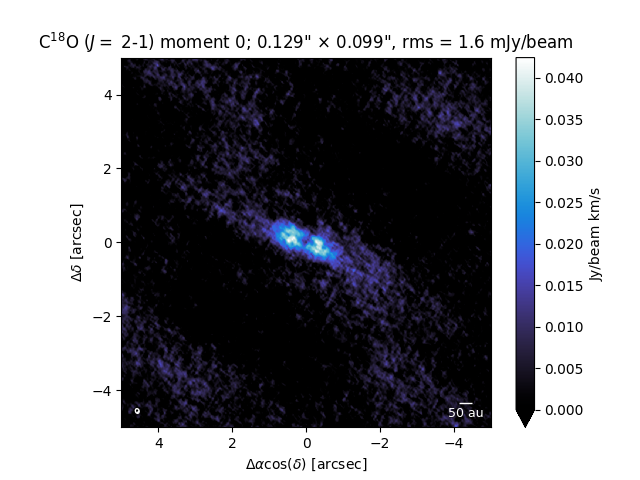

In [6]:
# plot mom0
fig, ax = plt.subplots()
norm = ImageNormalize(M0, vmin=0.0)
plot_2D_map(M0, X=x, Y=y, ax=ax, contour=False, beam=beam, scale=scale, pcolorfast_kw={'cmap': cpal, 'norm': norm}, cbar_kw={'label': 'Jy/beam km/s'})
ax.set(xlim=(5,-5), ylim=(-5,5), xlabel=r'$\Delta\alpha\cos(\delta)$ [arcsec]', ylabel=r'$\Delta\delta$ [arcsec]', title='C$^{{18}}$O ($J=$ 2-1) moment 0; {:.3f}" $\\times$ {:.3f}", rms = {:.1f} mJy/beam'.format(beam[0], beam[1], rms*1e3))

In [9]:
# calculate mom1
import bettermoments as bm
v = get_spectral_coord(header, which='vel')[cutout[0]]
# use only >=2sigma pixels
clip_th = 3.0 # sigma
data_croped = masked_data.copy()
data_croped[data_croped < clip_th * rms] = 0.0
#M1, _ = bm.collapse_first(velax=v, data=data_croped, rms=rms)
vcube = v[:, None, None] * np.ones(data_croped.shape)
weights = np.where(data_croped != 0.0, data_croped, 1e-10 * np.random.rand(data.size).reshape(data.shape)) # to avoid zero division error
M1 = np.average(vcube, weights=weights, axis=0)
npix = np.sum(data_croped != 0.0, axis=0)
M1 = np.where(npix >= 1.0, M1, np.nan)

[(3.0, -3.0),
 (-3.0, 3.0),
 Text(0.5, 0, '$\\Delta\\alpha\\cos(\\delta)$ [arcsec]'),
 Text(0, 0.5, '$\\Delta\\delta$  [arcsec]'),
 Text(0.5, 1.0, 'C$^{18}$O ($J=$ 2-1) moment 1 (3.0$\\sigma$ clip)')]

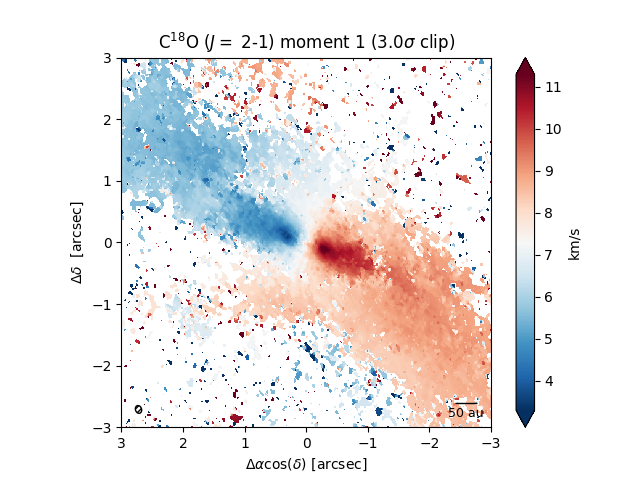

In [10]:
fig, ax = plt.subplots()
vrange = (-4, 4)
vsys = 7.3  # from Sai et al. 2021
norm = ImageNormalize(M1, vmin=vrange[0] + vsys, vmax=vrange[1] + vsys)
plot_2D_map(
    M1,
    X=x,
    Y=y,
    ax=ax,
    contour=False,
    beam=beam,
    scale=scale,
    pcolorfast_kw={"norm": norm, "cmap": "RdBu_r"},
    cbar_kw={"label": "km/s"},
    beam_kw={'color': 'black'},
    sbar_kw={'color': 'black'}
)
ax.set(
    xlim=(3, -3),
    ylim=(-3, 3),
    xlabel=r"$\Delta\alpha\cos(\delta)$ [arcsec]",
    ylabel=r"$\Delta\delta$  [arcsec]",
    title="C$^{{18}}$O ($J=$ 2-1) moment 1 ({:.1f}$\\sigma$ clip)".format(clip_th),
)


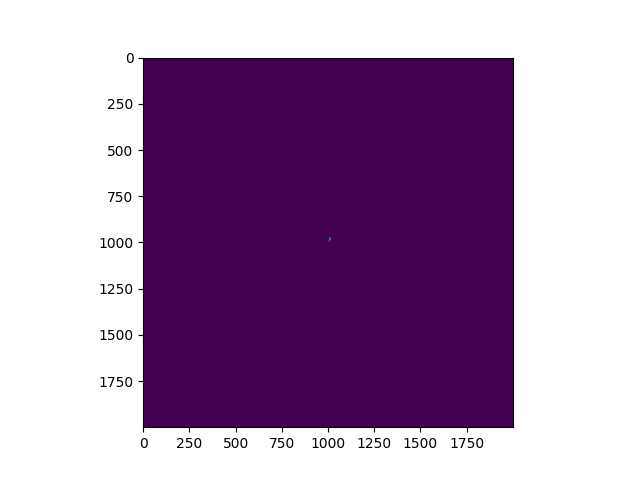

In [57]:
# Keplerian masking
from keplerian_mask import make_mask
dx = fitresult['component0']['peak'].ra.arcsec - header['CRVAL1'] * 3600
dy = fitresult['component0']['peak'].dec.arcsec - header['CRVAL2'] * 3600
kep_mask = make_mask(inc=incl, PA=PA, dist=140, mstar=1.6, vlsr=7.3, dx0=dx, dy0=dy, x_axis=x, y_axis=y, s_axis=np.zeros(1), v_axis=v*1000, r_max=1.4)



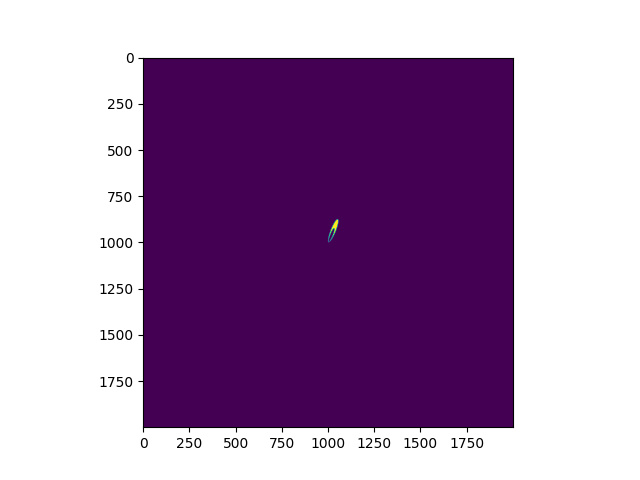

In [58]:
plt.figure()
plt.imshow(kep_mask.squeeze()[:,:,60])

In [4]:
from scipy.interpolate import interp2d, griddata
# masking to reduce the calculation time
position_range = (-4, 4) # in arcsec
velocity_range = (2, 12)
PA_pv = 69

mask_width = 0.1 / np.cos(np.radians(incl))
pos_tol = 0.5
vel_tol = 1.0

dpix = np.abs(header['CDELT1']) * 3600

v = get_spectral_coord(header, which='vel')
projected, polar = get_projected_coord(header, PA=PA_pv, incl=incl, center_coord=center_coord, which='both')
x_proj, y_proj = projected
# initial cutout
x_proj = x_proj[cutout[1:]]
y_proj = y_proj[cutout[1:]]

# fig, ax= plt.subplots()
# plot_2D_map(y_proj, X=x, Y=y, ax=ax)

pv_mask = np.zeros(data.shape[1:])
pv_mask[(x_proj >= position_range[0] - pos_tol) & (x_proj <= position_range[1] + pos_tol) & (y_proj >= -mask_width) & (y_proj <= mask_width)] = 1.0

# print(x.shape)
# fig, ax= plt.subplots()
# plot_2D_map(data[0] * pv_mask, X=x, Y=y, ax=ax, contour=False)

# interpolate
x_proj_masked = x_proj * pv_mask
y_proj_masked = y_proj * pv_mask
data_masked = data * pv_mask
data_masked = data_masked[(v >= velocity_range[0] - vel_tol) & (v <= velocity_range[1] + vel_tol)]
print(data_masked.shape)

# exclude zero
x_proj_masked = x_proj_masked[np.nonzero(x_proj_masked)].ravel()
y_proj_masked = y_proj_masked[np.nonzero(y_proj_masked)].ravel()
#data_masked = data_masked[np.nonzero(data_masked)]
print(np.count_nonzero(pv_mask), x_proj_masked.shape)
# new coordinates
x_proj_interp = np.arange(*position_range, dpix)
y_proj_interp = np.zeros_like(x_proj_interp)
print(x_proj_interp, y_proj_interp)

# im = data_masked[0]
# print(im[np.nonzero(im)].shape)

pvdiagram = np.array([griddata(np.array([x_proj_masked, y_proj_masked]).T, im[np.nonzero(im)], (x_proj_interp, y_proj_interp), method='cubic') for im in data_masked])
print(pvdiagram.shape)

#pvdiagram = np.array([interp2d(x_proj_masked, y_proj_masked, im[np.nonzero(im)], kind='cubic')(x_proj_interp, y_proj_interp) for im in data_masked])

v = v[(v >= velocity_range[0] - vel_tol) & (v <= velocity_range[1] + vel_tol)]



(72, 2000, 2000)
17999 (17999,)
[-4.0000000e+00 -3.9900000e+00 -3.9800000e+00 -3.9700000e+00
 -3.9600000e+00 -3.9500000e+00 -3.9400000e+00 -3.9300000e+00
 -3.9200000e+00 -3.9100000e+00 -3.9000000e+00 -3.8900000e+00
 -3.8800000e+00 -3.8700000e+00 -3.8600000e+00 -3.8500000e+00
 -3.8400000e+00 -3.8300000e+00 -3.8200000e+00 -3.8100000e+00
 -3.8000000e+00 -3.7900000e+00 -3.7800000e+00 -3.7700000e+00
 -3.7600000e+00 -3.7500000e+00 -3.7400000e+00 -3.7300000e+00
 -3.7200000e+00 -3.7100000e+00 -3.7000000e+00 -3.6900000e+00
 -3.6800000e+00 -3.6700000e+00 -3.6600000e+00 -3.6500000e+00
 -3.6400000e+00 -3.6300000e+00 -3.6200000e+00 -3.6100000e+00
 -3.6000000e+00 -3.5900000e+00 -3.5800000e+00 -3.5700000e+00
 -3.5600000e+00 -3.5500000e+00 -3.5400000e+00 -3.5300000e+00
 -3.5200000e+00 -3.5100000e+00 -3.5000000e+00 -3.4900000e+00
 -3.4800000e+00 -3.4700000e+00 -3.4600000e+00 -3.4500000e+00
 -3.4400000e+00 -3.4300000e+00 -3.4200000e+00 -3.4100000e+00
 -3.4000000e+00 -3.3900000e+00 -3.3800000e+00 -3.3700

75.92502285586241 0.9699783170695544


[(-4.0, 4.0),
 (1.0159999478139068, 12.872999951521056),
 Text(0.5, 0, 'Offset [arcsec]'),
 Text(0, 0.5, '$v_\\mathrm{LSR}$ [km s$^{-1}$]'),
 Text(0.5, 1.0, 'C$^{18}$O ($J=$ 2-1) \n PV Diagram (P.A. = 69$^{\\circ}$)')]

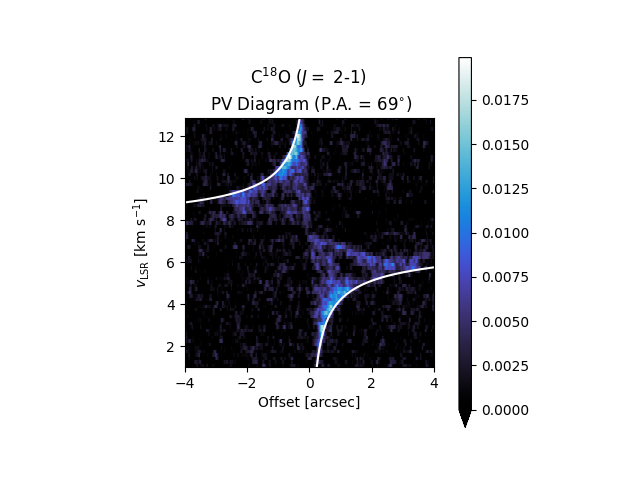

In [5]:
fig, ax = plt.subplots()
plot_2D_map(pvdiagram, X=x_proj_interp, Y=v, ax=ax, contour=False, pcolorfast_kw={'cmap': cpal, 'vmin': 0.0})
#ax.invert_xaxis()
#ax.set(xlim=(-3, 3), aspect=1.)
import astropy.constants as ac 
import astropy.units as u
mstar = 1.6 * u.Msun
vkep_red = np.sqrt(ac.G * mstar / np.abs(x_proj_interp[x_proj_interp < 0.0] * 140 * u.au)) * np.sin(np.radians(incl))
vkep_blue = -np.sqrt(ac.G * mstar / np.abs(x_proj_interp[x_proj_interp > 0.0] * 140 * u.au)) * np.sin(np.radians(incl))
#ax.plot(x_proj_interp, vkep.to(u.km/u.s).value, color='white')
print(incl, np.sin(np.radians(incl)))
ax.plot(x_proj_interp[x_proj_interp < 0.0], vkep_red.to(u.km/u.s).value + 7.3, color='white')
ax.plot(x_proj_interp[x_proj_interp > 0.0], vkep_blue.to(u.km/u.s).value + 7.3, color='white')
ax.set(xlim=(-4, 4), ylim=(v.min(), v.max()), xlabel='Offset [arcsec]', ylabel=r'$v_\mathrm{LSR}$ [km s$^{-1}$]', title='C$^{18}$O ($J=$ 2-1) \n PV Diagram (P.A. = 69$^{\\circ}$)')

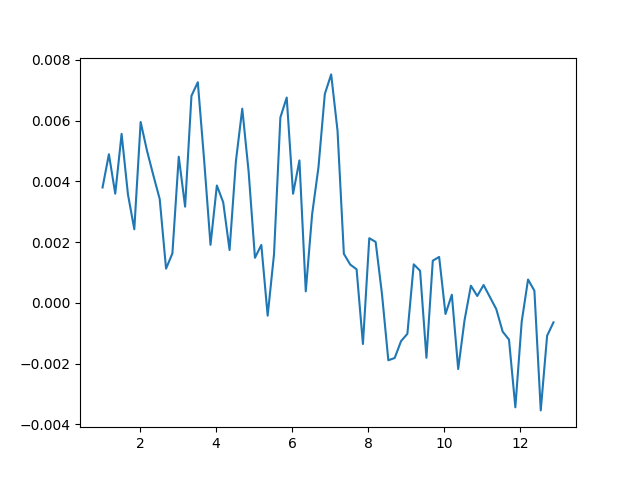

In [77]:
plt.figure()
plt.plot(v, pvdiagram[:,420])

In [63]:
rng = np.random.default_rng()

points = rng.random((1000, 2))
points.shape

(1000, 2)